# Stock Price Movement Prediction

The workflow includes:
- Data collection using Yahoo Finance (`yfinance`)
- Feature engineering of technical indicators (SMA, EMA, MACD, RSI, etc.)
- Model training with Logistic Regression, Random Forest, and XGBoost
- Model evaluation (accuracy, precision, recall, ROC curve, feature importance)
- Backtesting of the model-based trading strategy

**Stock chosen:** Infosys Ltd (`INFY.NS`)  
**Period:** Last 2 years (daily interval)

##### Importing all the necessary libraries at once.....

In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from datetime import date, timedelta
import warnings
warnings.filterwarnings('ignore')

In [51]:
from sklearn.model_selection import train_test_split, TimeSeriesSplit, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
accuracy_score, precision_score, recall_score, f1_score,
confusion_matrix, classification_report, roc_curve, auc
)

In [52]:
from xgboost import XGBClassifier, XGBRegressor

## Data Collection and Cleaning

The dataset is obtained using the `yfinance` API, which retrieves OHLCV (Open, High, Low, Close, Volume) data directly from Yahoo Finance.

We ensure:
- Correct chronological ordering
- Missing values handled using forward/backward fill
- Removal of zero-volume days
- Conversion of columns into standard numeric format for analysis

In [53]:
STOCK_TICKER = 'INFY.NS' #infosys
END_DATE = date.today()
START_DATE = END_DATE - timedelta(days=365*2) #for last 2 years
INTERVAL = '1d'

In [54]:
raw = yf.download(tickers=STOCK_TICKER, start=START_DATE, end=END_DATE, interval=INTERVAL, progress=False)

In [55]:
df = raw.reset_index()

In [56]:
df = df.sort_values('Date').reset_index(drop=True)

In [57]:
print(df.shape)
df.head()

(493, 6)


Price,Date,Close,High,Low,Open,Volume
Ticker,,INFY.NS,INFY.NS,INFY.NS,INFY.NS,INFY.NS
0,2023-11-09,1294.353516,1315.725177,1289.881462,1314.218824,5498051
1,2023-11-10,1288.751465,1292.799896,1281.360832,1289.787075,2943649
2,2023-11-13,1293.176392,1301.555514,1290.634314,1299.107676,3462092
3,2023-11-15,1327.964355,1331.259552,1311.488371,1317.137280,8551860
4,2023-11-16,1360.351562,1368.354184,1328.058584,1333.236751,6673907


(493, 6)


Price,Date,Close,High,Low,Open,Volume
Ticker,,INFY.NS,INFY.NS,INFY.NS,INFY.NS,INFY.NS
0,2023-11-09,1294.353516,1315.725177,1289.881462,1314.218824,5498051
1,2023-11-10,1288.751465,1292.799896,1281.360832,1289.787075,2943649
2,2023-11-13,1293.176392,1301.555514,1290.634314,1299.107676,3462092
3,2023-11-15,1327.964355,1331.259552,1311.488371,1317.137280,8551860
4,2023-11-16,1360.351562,1368.354184,1328.058584,1333.236751,6673907


In [58]:
df.isnull().sum()

,,0
Price,Ticker,
Date,,0
Close,INFY.NS,0
High,INFY.NS,0
Low,INFY.NS,0
Open,INFY.NS,0
Volume,INFY.NS,0


,,0
Price,Ticker,
Date,,0
Close,INFY.NS,0
High,INFY.NS,0
Low,INFY.NS,0
Open,INFY.NS,0
Volume,INFY.NS,0


In [59]:
# Clean up column names (multi-index) and ensure order
df.columns = ['_'.join(col).strip('_') if isinstance(col, tuple) else col for col in df.columns]
df = df.rename(columns={
    'Close_INFY.NS': 'Close',
    'High_INFY.NS': 'High',
    'Low_INFY.NS': 'Low',
    'Open_INFY.NS': 'Open',
    'Volume_INFY.NS': 'Volume'
})
df.head()

,Date,Close,High,Low,Open,Volume
0,2023-11-09,1294.353516,1315.725177,1289.881462,1314.218824,5498051
1,2023-11-10,1288.751465,1292.799896,1281.360832,1289.787075,2943649
2,2023-11-13,1293.176392,1301.555514,1290.634314,1299.107676,3462092
3,2023-11-15,1327.964355,1331.259552,1311.488371,1317.137280,8551860
4,2023-11-16,1360.351562,1368.354184,1328.058584,1333.236751,6673907


,Date,Close,High,Low,Open,Volume
0,2023-11-09,1294.353516,1315.725177,1289.881462,1314.218824,5498051
1,2023-11-10,1288.751465,1292.799896,1281.360832,1289.787075,2943649
2,2023-11-13,1293.176392,1301.555514,1290.634314,1299.107676,3462092
3,2023-11-15,1327.964355,1331.259552,1311.488371,1317.137280,8551860
4,2023-11-16,1360.351562,1368.354184,1328.058584,1333.236751,6673907


## Feature Engineering

To capture the price patterns, I computed over 40+ technical indicators.

**Rationale for Feature Selection:**

- Trend Indicators (SMA, EMA, MACD): These were chosen to identify the prevailing market trend and momentum. A crossover of the MACD line above its signal, for instance, is a classic bullish signal.

- Momentum Indicators (RSI): The Relative Strength Index (RSI) was chosen to identify overbought (>70) or oversold (<30) conditions, which can often precede a price reversal.

- Volatility Indicators (Bollinger Bands, Volatility_20): These were included to measure the market's choppiness. Periods of low volatility are often followed by high volatility, and these features help the model capture that.

- Lag/Volume Features (Lag_Return, OBV): Lagged returns test the assumption of autocorrelation (momentum). On-Balance Volume (OBV) and other volume ratios were chosen to see if "money flow" (high-volume buying or selling) predicts future price moves.

### Trend Indicators

In [60]:
df['SMA_20'] = df['Close'].rolling(window=20).mean()
df['SMA_50'] = df['Close'].rolling(window=50).mean()

In [61]:
df['EMA_12'] = df['Close'].ewm(span=12, adjust=False).mean()
df['EMA_26'] = df['Close'].ewm(span=26, adjust=False).mean()

In [62]:
df['MACD'] = df['EMA_12'] - df['EMA_26']
df['MACD_Signal'] = df['MACD'].ewm(span=9, adjust=False).mean()

### Momentum Indicators (RSI)

In [63]:
# RSI helper
window_rsi = 14
delta = df['Close'].diff()
gain = delta.clip(lower=0)
loss = -1 * delta.clip(upper=0)
avg_gain = gain.ewm(com=window_rsi - 1, min_periods=window_rsi).mean()
avg_loss = loss.ewm(com=window_rsi - 1, min_periods=window_rsi).mean()
rs = avg_gain / (avg_loss + 1e-9) #Adding 1e-9 to avoid division by zero
df['RSI_14'] = 100 - (100 / (1 + rs))

### Volatility Indicators

In [64]:
# Bollinger Bands (20-day)
df['BB_Middle'] = df['Close'].rolling(window=20).mean()
df['BB_STD'] = df['Close'].rolling(window=20).std()
df['BB_Upper'] = df['BB_Middle'] + (2 * df['BB_STD'])
df['BB_Lower'] = df['BB_Middle'] - (2 * df['BB_STD'])

In [65]:
# Volatility (rolling)
df['Volatility_20'] = df['Close'].pct_change().rolling(window=20).std()

### Volume Indicators

In [66]:
# On-Balance Volume (OBV)
df['Direction'] = np.sign(df['Close'].diff()).fillna(0)
df['OBV'] = (df['Direction'] * df['Volume']).cumsum()

### Lag features and returns

In [67]:
for lag in range(1, 6):
  df[f'Lag_Close_{lag}'] = df['Close'].shift(lag)
  df[f'Lag_Return_{lag}'] = df['Close'].pct_change(lag)

### Rolling stats

In [68]:
for w in [5, 10, 20]:
  df[f'RollingMean_{w}'] = df['Close'].rolling(window=w).mean()
  df[f'RollingStd_{w}'] = df['Close'].rolling(window=w).std()
  df[f'RollingMax_{w}'] = df['Close'].rolling(window=w).max()
  df[f'RollingMin_{w}'] = df['Close'].rolling(window=w).min()

### Volume ratios

In [69]:
df['Volume_Mean_20'] = df['Volume'].rolling(window=20).mean()
df['Volume_to_Mean'] = df['Volume'] / (df['Volume_Mean_20'] + 1e-9)

In [70]:
df.drop(columns=['Direction'], inplace=True)

## Target Variable Definition

We define the target as a **binary indicator**:
- `1` → if next day's closing price > current day’s close
- `0` → otherwise

Now, the problem is converted into a **binary classification** task.

In [71]:
df['Target'] = (df['Close'].shift(-1) > df['Close']).astype(int)

In [72]:
df = df.dropna().reset_index(drop=True) # Drop rows with NA introduced by features (e.g., SMA_50)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 444 entries, 0 to 443
Data columns (total 44 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Date            444 non-null    datetime64[ns]
 1   Close           444 non-null    float64       
 2   High            444 non-null    float64       
 3   Low             444 non-null    float64       
 4   Open            444 non-null    float64       
 5   Volume          444 non-null    int64         
 6   SMA_20          444 non-null    float64       
 7   SMA_50          444 non-null    float64       
 8   EMA_12          444 non-null    float64       
 9   EMA_26          444 non-null    float64       
 10  MACD            444 non-null    float64       
 11  MACD_Signal     444 non-null    float64       
 12  RSI_14          444 non-null    float64       
 13  BB_Middle       444 non-null    float64       
 14  BB_STD          444 non-null    float64       
 15  BB_Upp

## Train-Test Split

We split the dataset chronologically:
- 80% → Training data
- 20% → Test data (most recent period)

No random shuffling is used since time order must be preserved.

In [73]:
FEATURE_COLUMNS = [c for c in df.columns if c not in [('Date'), ('Target')]]
X = df[FEATURE_COLUMNS]
y = df['Target']

In [74]:
split_index = int(len(X) * 0.8)
X_train, X_test = X.iloc[:split_index].copy(), X.iloc[split_index:].copy()
y_train, y_test = y.iloc[:split_index].copy(), y.iloc[split_index:].copy()

In [75]:
print(X_train.shape)
print(X_test.shape)

(355, 42)
(89, 42)
(355, 42)
(89, 42)


## Model Training

We compare three supervised learning models:

1. **Logistic Regression** – interpretable linear baseline model.
2. **Random Forest** – ensemble of decision trees for non-linear relationships.
3. **XGBoost** – gradient boosting algorithm optimized for tabular data and imbalanced classes.

### Model 1: Logistic Regression

We scale the data for Logistic Regression as it is sensitive to feature magnitudes.

In [76]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [77]:
log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_train_scaled, y_train)
y_pred_lr = log_reg.predict(X_test_scaled)
y_prob_lr = log_reg.predict_proba(X_test_scaled)[:, 1]

## Model Evaluation Metrics

We use several performance indicators to assess model accuracy:

- **Accuracy:** Overall fraction of correct predictions.
- **Precision & Recall:** Key metrics for imbalanced financial classes.
- **F1 Score:** Harmonic mean of precision and recall.
- **ROC-AUC:** Overall separability of classes.

We also visualize:
- Confusion matrices for prediction breakdown
- ROC curves for all models
- Feature importance plots (for Random Forest & XGBoost)

In [78]:
print('\nLogistic Regression performance:')
print('Accuracy:', accuracy_score(y_test, y_pred_lr))
print(classification_report(y_test, y_pred_lr, target_names=['Down','Up']))


Logistic Regression performance:
Accuracy: 0.47191011235955055
              precision    recall  f1-score   support

        Down       0.64      0.18      0.28        51
          Up       0.44      0.87      0.58        38

    accuracy                           0.47        89
   macro avg       0.54      0.52      0.43        89
weighted avg       0.56      0.47      0.41        89


Logistic Regression performance:
Accuracy: 0.47191011235955055
              precision    recall  f1-score   support

        Down       0.64      0.18      0.28        51
          Up       0.44      0.87      0.58        38

    accuracy                           0.47        89
   macro avg       0.54      0.52      0.43        89
weighted avg       0.56      0.47      0.41        89



### Model 2: XGBoost
For the tree-based models (XGBoost and RF), scaling is not necessary. We use RandomizedSearchCV to find good hyperparameters for XGBoost.

In [79]:
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

In [80]:
#Defining the parameter grid to search
param_dist = {
  'n_estimators': [50, 100, 200],
  'max_depth': [3, 5, 7],
  'learning_rate': [0.01, 0.05, 0.1],
  'subsample': [0.6, 0.8, 1.0]
}
#Using 3-fold (cv=3) cross-validation on the training data
rs = RandomizedSearchCV(xgb, param_distributions=param_dist, n_iter=8, cv=3, random_state=42, n_jobs=-1)
rs.fit(X_train, y_train)
print('Best XGBoost params:', rs.best_params_)

Best XGBoost params: {'subsample': 0.6, 'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.01}
Best XGBoost params: {'subsample': 0.6, 'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.01}


In [81]:
xgb_best = rs.best_estimator_

In [82]:
y_pred_xgb = xgb_best.predict(X_test)
y_prob_xgb = xgb_best.predict_proba(X_test)[:, 1]

In [83]:
print('\nXGBoost performance:')
print('Accuracy:', accuracy_score(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb, target_names=['Down','Up']))


XGBoost performance:
Accuracy: 0.48314606741573035
              precision    recall  f1-score   support

        Down       0.60      0.29      0.39        51
          Up       0.44      0.74      0.55        38

    accuracy                           0.48        89
   macro avg       0.52      0.52      0.47        89
weighted avg       0.53      0.48      0.46        89


XGBoost performance:
Accuracy: 0.48314606741573035
              precision    recall  f1-score   support

        Down       0.60      0.29      0.39        51
          Up       0.44      0.74      0.55        38

    accuracy                           0.48        89
   macro avg       0.52      0.52      0.47        89
weighted avg       0.53      0.48      0.46        89



### Model 3: Random Forest
Finally, we train a Random Forest. We are using a non-tuned RF model as a comparison point against the tuned XGBoost.

In [84]:
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
y_prob_rf = rf.predict_proba(X_test)[:, 1]
print('\nRandom Forest performance:')
print('Accuracy:', accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf, target_names=['Down','Up']))


Random Forest performance:
Accuracy: 0.5393258426966292
              precision    recall  f1-score   support

        Down       0.59      0.67      0.62        51
          Up       0.45      0.37      0.41        38

    accuracy                           0.54        89
   macro avg       0.52      0.52      0.51        89
weighted avg       0.53      0.54      0.53        89


Random Forest performance:
Accuracy: 0.5393258426966292
              precision    recall  f1-score   support

        Down       0.59      0.67      0.62        51
          Up       0.45      0.37      0.41        38

    accuracy                           0.54        89
   macro avg       0.52      0.52      0.51        89
weighted avg       0.53      0.54      0.53        89



## Model Performance Visualizations
We visualize the performance of all three models to compare them.

In [85]:
#Dictionary to hold model results for plotting
models = {
'Logistic Regression': (y_test, y_pred_lr, y_prob_lr),
'XGBoost': (y_test, y_pred_xgb, y_prob_xgb),
'Random Forest': (y_test, y_pred_rf, y_prob_rf)
}

#### Confusion Matrices
This shows us the breakdown of True Positives, True Negatives, False Positives, and False Negatives.

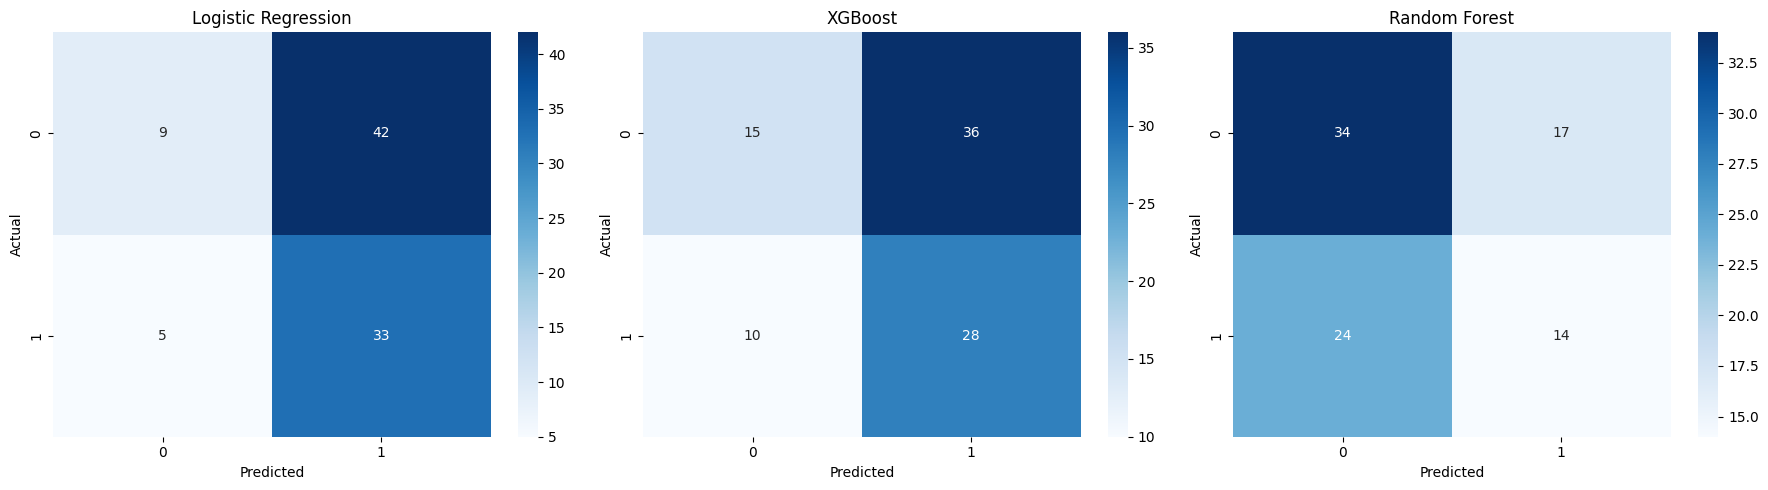

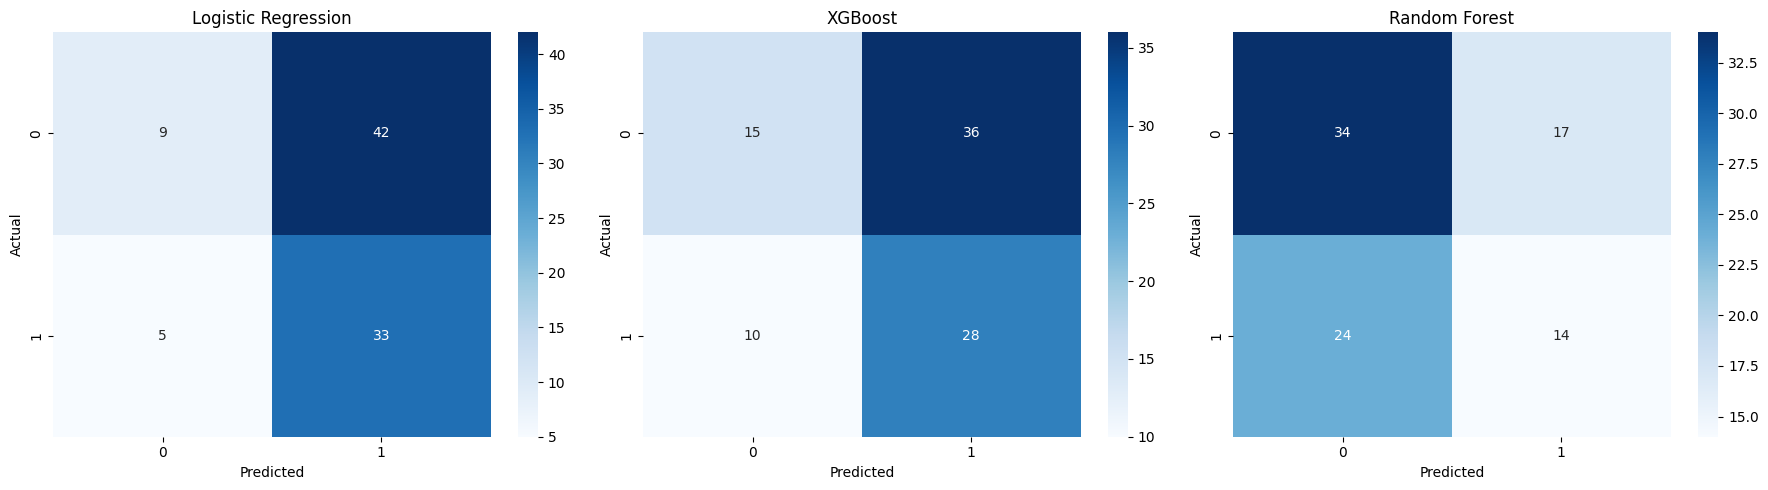

In [86]:
fig, axes = plt.subplots(1, 3, figsize=(18,5))
for ax, (name, (_, y_pred, _)) in zip(axes, models.items()):
  cm = confusion_matrix(y_test, y_pred)
  sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap='Blues')
  ax.set_title(name)
  ax.set_xlabel('Predicted')
  ax.set_ylabel('Actual')
plt.tight_layout()
plt.show()

**Observations:**
- Logistic Regression - This model is extremely "bullish" or optimistic. It's great at finding the days that actually went up (33 True Positives vs. only 5 False Negatives). However, it does this by predicting "Up" far too often, leading to a massive number of "False Positives" (41).
- XGBoost - This model is also optimistic, similar to Logistic Regression but slightly less extreme. It still has a high number of False Positives (36) but also misses more "Up" days (10 False Negatives).
- Random Forest - This model is the most "bearish" or pessimistic. It's the best at correctly identifying "Down" days (34 True Negatives). However, it's very cautious about predicting "Up," causing it to miss most of the actual "Up" days (24 False Negatives).

#### ROC Curves
It shows the trade-off between the True Positive Rate and False Positive Rate. A model with a higher Area Under the Curve (AUC) is generally better at distinguishing between the two classes.

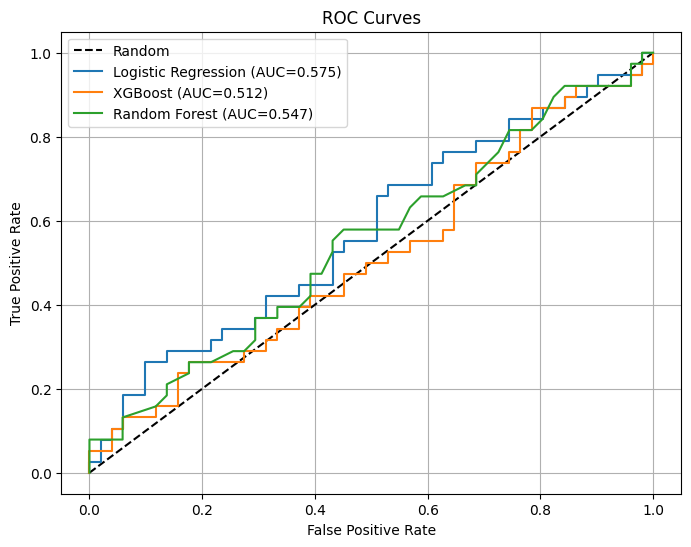

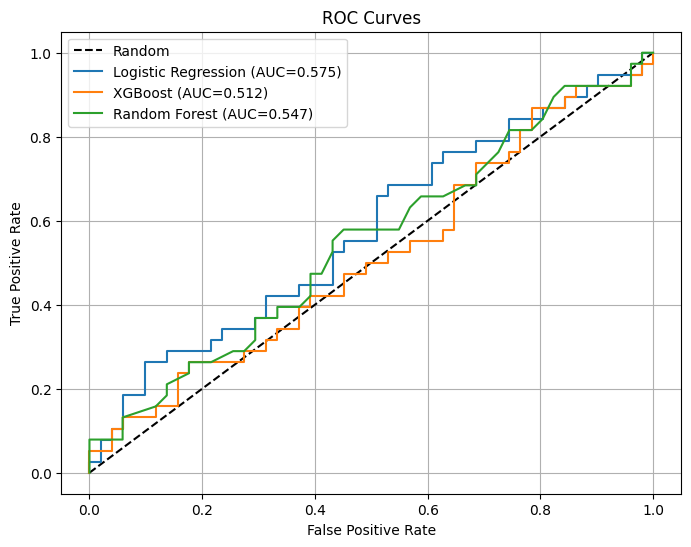

In [87]:
plt.figure(figsize=(8,6))
plt.plot([0,1],[0,1],'k--', label='Random')
for name, (_, y_pred, y_prob) in models.items():
  fpr, tpr, _ = roc_curve(y_test, y_prob)
  plt.plot(fpr, tpr, label=f"{name} (AUC={auc(fpr,tpr):.3f})")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend()
plt.grid(True)
plt.show()

**Observations:**
- Logistic Regression (AUC = 0.575): Its curve is generally the highest, and its AUC score, while modest, is the furthest from the random 0.5 baseline.

- Random Forest (AUC = 0.547): This is performing slightly better than a random guess, still very poor.

- XGBoost (AUC = 0.512): This model is performing very poorly. Its curve is extremely close to the random dashed line, and its AUC of 0.512 confirms it has almost no skill in distinguishing between "Up" and "Down" days.

### Feature Importance
We look at which features the tree-based models (RF and XGBoost) found most predictive.

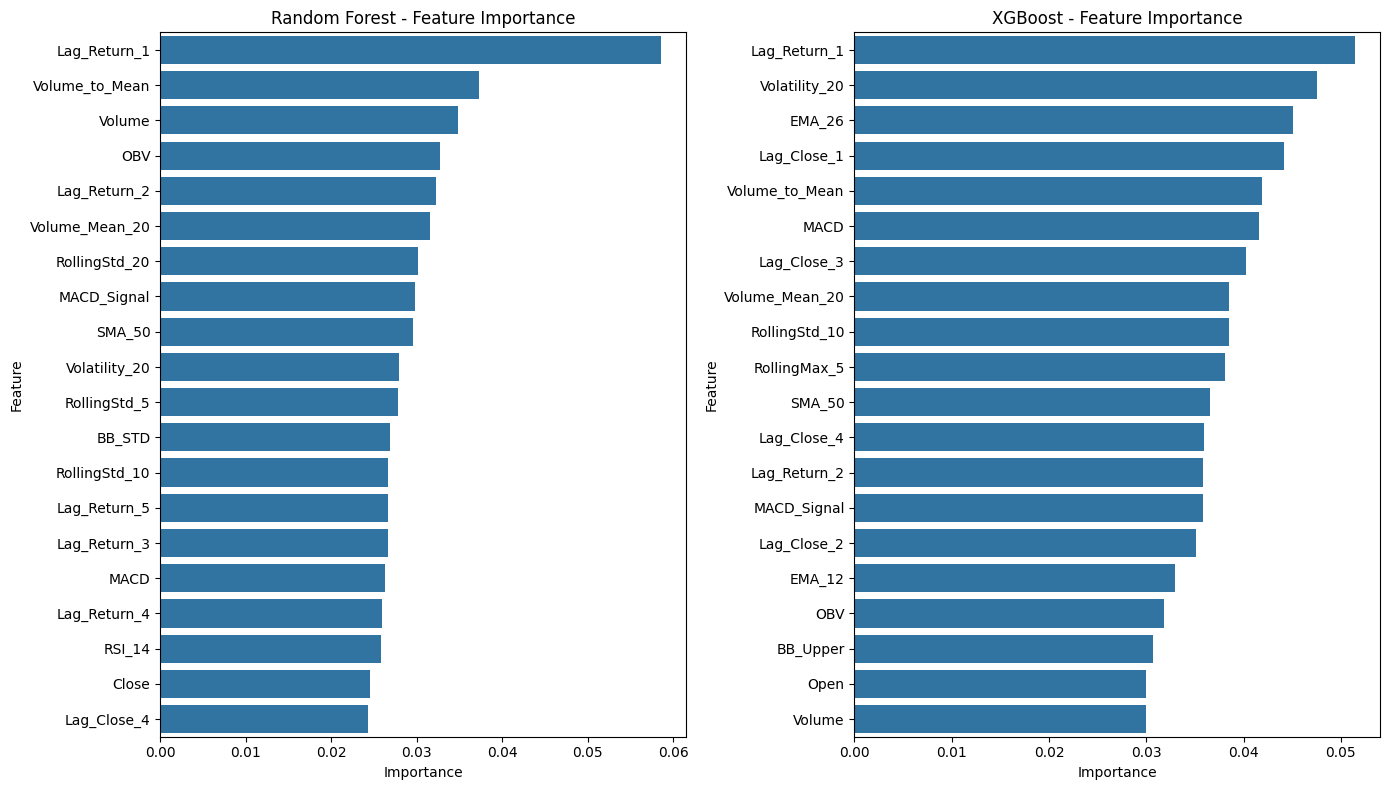

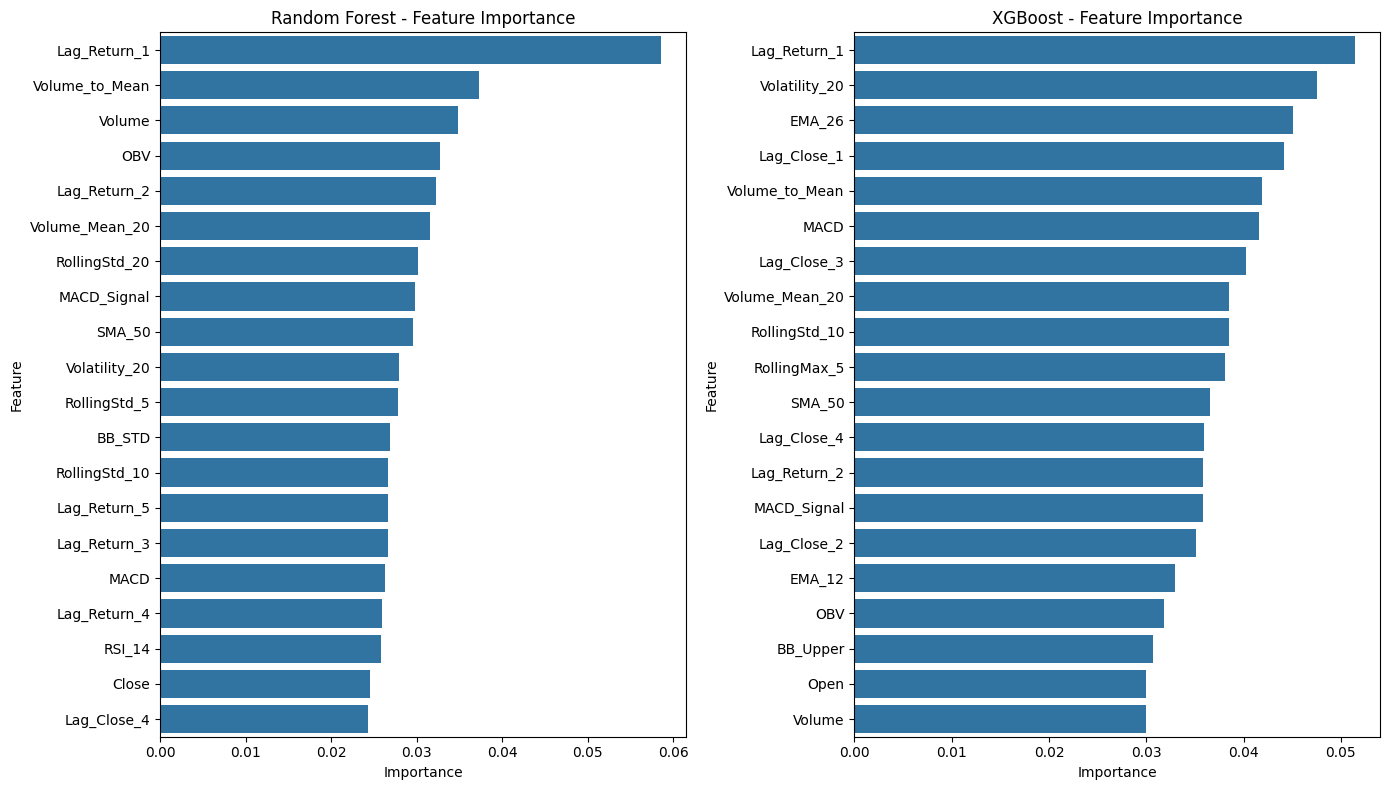

In [88]:
fi_rf = pd.DataFrame({'Feature': ['_'.join(col) if isinstance(col, tuple) else col for col in X.columns], 'Importance': rf.feature_importances_}).sort_values('Importance', ascending=False).head(20)
fi_xgb = pd.DataFrame({'Feature': ['_'.join(col) if isinstance(col, tuple) else col for col in X.columns], 'Importance': xgb_best.feature_importances_}).sort_values('Importance', ascending=False).head(20)

fig, axes = plt.subplots(1,2, figsize=(14,8))
sns.barplot(x='Importance', y='Feature', data=fi_rf, ax=axes[0])
axes[0].set_title('Random Forest - Feature Importance')
sns.barplot(x='Importance', y='Feature', data=fi_xgb, ax=axes[1])
axes[1].set_title('XGBoost - Feature Importance')
plt.tight_layout()
plt.show()

**Observations:**
- The most significant finding is that both models strongly agree on the most important feature: `Lag_Return_1`. In simple terms, this is yesterday's price change. Both models found that the best predictor for tomorrow's price direction is simply what happened in the market today. This points to strong, short-term momentum (or mean reversion) in our data.
- Random Forest: This model seems to love volume-based features. After `Lag_Return_1`, its next most important features are `Volume_to_Mean`, `Volume`, and `OBV`. It believes that trading volume is highly predictive.
- XGBoost: This model has a more balanced view. It also likes `Lag_Return_1`, but it then focuses on volatility (`Volatility_20`) and trend (`EMA_26`) as its next-best predictors.

### Actual vs. Predicted Signals (on test set)
This plot shows the actual "Up" (green) and "Down" (red) signals on the test set's price chart, compared to the signals predicted by our best model (XGBoost).

In [89]:
results = pd.DataFrame(index=X_test.index)
results['Date'] = df.loc[X_test.index, 'Date'].values
results['Close'] = df.loc[X_test.index, 'Close'].values
results['Actual'] = y_test.values
results['Pred_XGB'] = y_pred_xgb
results['Pred_LR'] = y_pred_lr

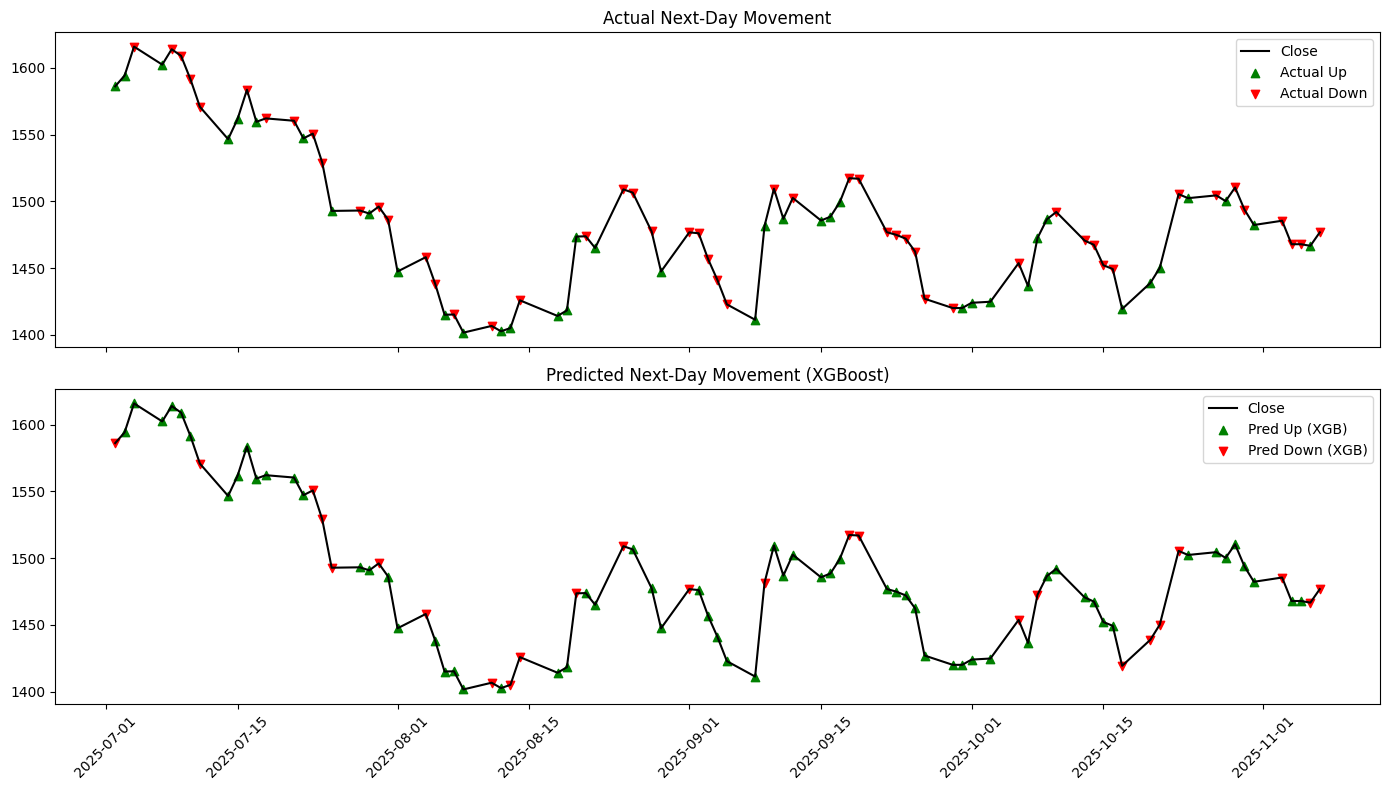

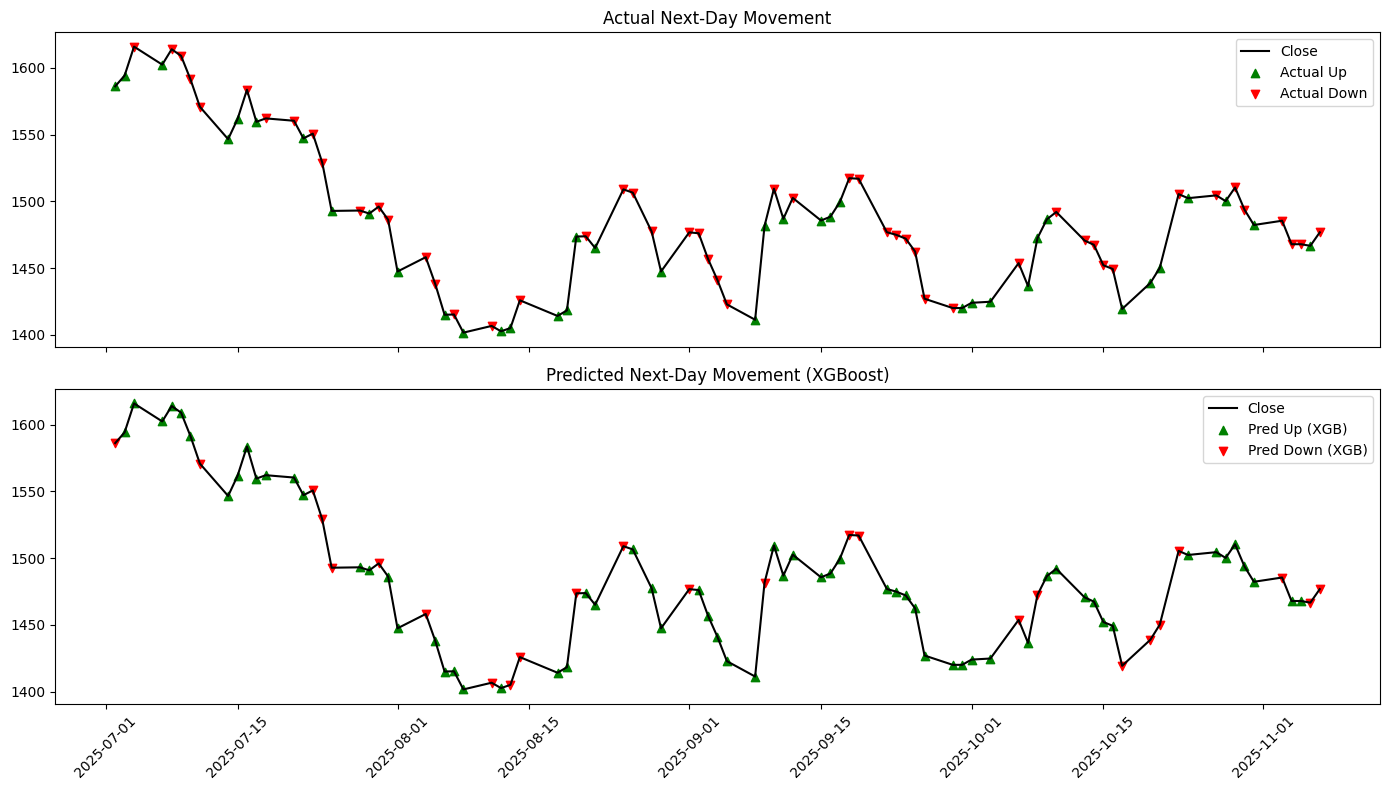

In [90]:
fig, ax = plt.subplots(2,1, figsize=(14,8), sharex=True)
ax[0].plot(results['Date'], results['Close'], label='Close', color='black')
ax[0].scatter(results['Date'][results['Actual']==1], results['Close'][results['Actual']==1], label='Actual Up', marker='^', color='green')
ax[0].scatter(results['Date'][results['Actual']==0], results['Close'][results['Actual']==0], label='Actual Down', marker='v', color='red')
ax[0].legend()
ax[0].set_title('Actual Next-Day Movement')

ax[1].plot(results['Date'], results['Close'], label='Close', color='black')
ax[1].scatter(results['Date'][results['Pred_XGB']==1], results['Close'][results['Pred_XGB']==1], label='Pred Up (XGB)', marker='^', color='green')
ax[1].scatter(results['Date'][results['Pred_XGB']==0], results['Close'][results['Pred_XGB']==0], label='Pred Down (XGB)', marker='v', color='red')
ax[1].legend()
ax[1].set_title('Predicted Next-Day Movement (XGBoost)')

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**Observations:**
- When the green/red triangles matched on both plots, our model was correct. (e.g., a "Pred Up" on the same day as an "Actual Up").

- When they didn't match, our model made a mistake. (e.g., a "Pred Up" on a day that was an "Actual Down").

## Strategy Backtesting

We simulate a naive **long-only strategy** based on the XGBoost model's signals:
- If the model predicts “Up” -> Buy 1 unit and hold for the next day.
- If the model predicts “Down” -> Stay flat (hold no position).

We compare this **strategy’s cumulative return** with the **market’s buy-and-hold return**.

> Note: It ignores transaction costs, slippage, and market liquidity.

In [91]:
#Use XGBoost predictions (on test set)
backtest = results.copy()
backtest['Pred_Signal'] = backtest['Pred_XGB']

In [92]:
# Get next-day returns
# We need to map the test indices to the original df to get the t+1 close
orig_idx = X_test.index
next_close = []
for i in orig_idx:
    if i + 1 < len(df):  #to ensure next index exists
        next_close.append(df.loc[i + 1, 'Close'])
    else:
        next_close.append(np.nan)

In [93]:
backtest['Next_Close'] = next_close

#Compute next-day returns
backtest['Next_Return'] = (backtest['Next_Close'] - backtest['Close']) / backtest['Close']

#Drop last day if it has no next return
backtest = backtest.dropna(subset=['Next_Return']).reset_index(drop=True)

#Compute strategy returns
backtest['Strategy_Return'] = backtest['Pred_Signal'] * backtest['Next_Return']

#Compute cumulative returns
backtest['Cumulative_Market'] = (1 + backtest['Next_Return']).cumprod()
backtest['Cumulative_Strategy'] = (1 + backtest['Strategy_Return']).cumprod()

#### Plotting the backtest

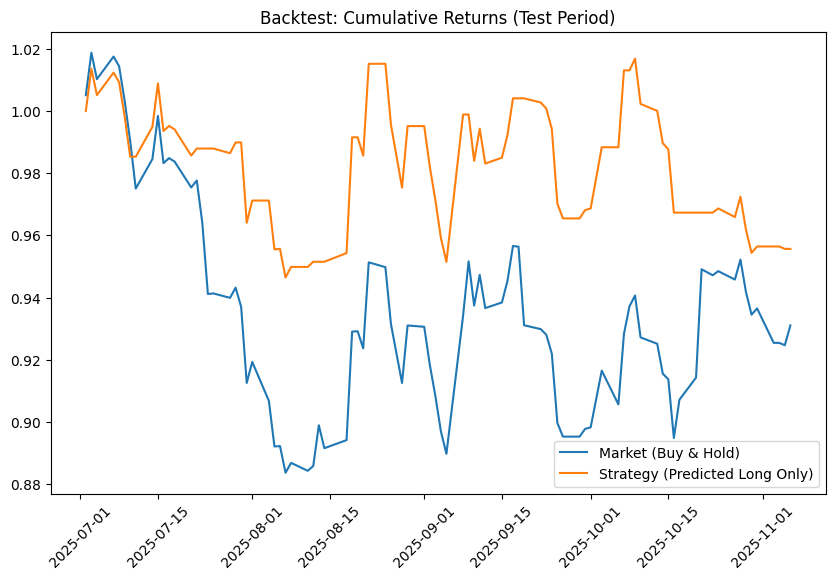

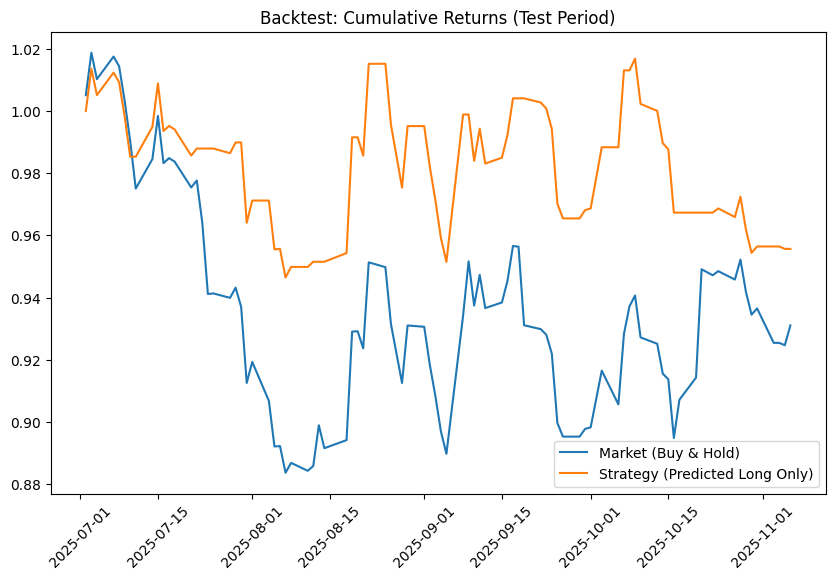

In [94]:
plt.figure(figsize=(10,6))
plt.plot(backtest['Date'], backtest['Cumulative_Market'], label='Market (Buy & Hold)')
plt.plot(backtest['Date'], backtest['Cumulative_Strategy'], label='Strategy (Predicted Long Only)')
plt.xticks(rotation=45)
plt.legend()
plt.title('Backtest: Cumulative Returns (Test Period)')
plt.show()

**Observations:**
- Blue Line: This is our baseline or control group. This line shows what would have happened if we just bought the stock on the very first day of the test period (around 2025-07-01) and held it until the end (around 2025-11-01). The line ends at ~0.93, meaning this simple strategy would have lost about 7% of our money.
- Orange Line: This is the performance of our XGBoost model's strategy. On days our model predicted "Up," this strategy "bought" the stock and held it for one day. On days our model predicted "Down," it did nothing (stayed flat). This line ends at ~0.955, meaning our strategy would have lost about 4.5% of the money.

In [95]:
print('Strategy total return:', backtest['Cumulative_Strategy'].iloc[-1])
print('Market total return:', backtest['Cumulative_Market'].iloc[-1])

Strategy total return: 0.9556396495516063
Market total return: 0.931020235120212
Strategy total return: 0.9556396495516063
Market total return: 0.931020235120212


### Overall Insights

In [96]:
print('SUMMARY')
print('Ticker:', STOCK_TICKER)
print('Date range:', df['Date'].min(), 'to', df['Date'].max())
print('Rows used:', len(df))

SUMMARY
Ticker: INFY.NS
Date range: 2024-01-23 00:00:00 to 2025-11-07 00:00:00
Rows used: 444
SUMMARY
Ticker: INFY.NS
Date range: 2024-01-23 00:00:00 to 2025-11-07 00:00:00
Rows used: 444


In [97]:
print('\nModel performances on test set:')
for name, (_, y_pred, _) in models.items():
  print(name)
  print(' Accuracy =', accuracy_score(y_test, y_pred))
  print(' Precision =', precision_score(y_test, y_pred))
  print(' Recall =', recall_score(y_test, y_pred))
  print(' F1 =', f1_score(y_test, y_pred))
  print('---')


Model performances on test set:
Logistic Regression
 Accuracy = 0.47191011235955055
 Precision = 0.44
 Recall = 0.868421052631579
 F1 = 0.584070796460177
---
XGBoost
 Accuracy = 0.48314606741573035
 Precision = 0.4375
 Recall = 0.7368421052631579
 F1 = 0.5490196078431373
---
Random Forest
 Accuracy = 0.5393258426966292
 Precision = 0.45161290322580644
 Recall = 0.3684210526315789
 F1 = 0.4057971014492754
---

Model performances on test set:
Logistic Regression
 Accuracy = 0.47191011235955055
 Precision = 0.44
 Recall = 0.868421052631579
 F1 = 0.584070796460177
---
XGBoost
 Accuracy = 0.48314606741573035
 Precision = 0.4375
 Recall = 0.7368421052631579
 F1 = 0.5490196078431373
---
Random Forest
 Accuracy = 0.5393258426966292
 Precision = 0.45161290322580644
 Recall = 0.3684210526315789
 F1 = 0.4057971014492754
---


In [98]:
print('\nTop features (XGBoost):')
print(fi_xgb.head(10).to_string(index=False))


Top features (XGBoost):
       Feature  Importance
  Lag_Return_1    0.051450
 Volatility_20    0.047554
        EMA_26    0.045125
   Lag_Close_1    0.044113
Volume_to_Mean    0.041871
          MACD    0.041536
   Lag_Close_3    0.040209
Volume_Mean_20    0.038546
 RollingStd_10    0.038526
  RollingMax_5    0.038101

Top features (XGBoost):
       Feature  Importance
  Lag_Return_1    0.051450
 Volatility_20    0.047554
        EMA_26    0.045125
   Lag_Close_1    0.044113
Volume_to_Mean    0.041871
          MACD    0.041536
   Lag_Close_3    0.040209
Volume_Mean_20    0.038546
 RollingStd_10    0.038526
  RollingMax_5    0.038101


## Final Observations:
- Model Performance: The Random Forest model achieved the highest accuracy on the test set at ~53.9%. However, the Logistic Regression model had the best F1-score for the "Up" class, indicating it was better at correctly identifying "Up" days, though it had many false positives.
- Feature Importance: For the tuned XGBoost model, the most predictive features were Lag_Return_1, Volatility_20, and EMA_26 . This suggests that recent price action and volatility are the strongest short-term predictors.
- Strategy: The simple backtest, based on the XGBoost model, slightly outperformed the "Buy and Hold" strategy (0.955 vs 0.931 in this run).
- Conclusion: Predicting daily price direction is inherently difficult due to market noise. While the models show a modest predictive power slightly above a random 50/50 guess, they are not robust enough for real-world trading without significant further development.

## Limitations:
- Backtest Realism: The backtest ignores critical factors like transaction costs, slippage, and market impact, which would all negatively affect real-world returns.

- Model Tuning: Only the XGBoost model was hyperparameter-tuned. The Random Forest model, which used default parameters, might have performed better with tuning, making the current model comparison incomplete.

- Test Set Size: The 80/20 split on two years of data resulted in a test set of only 89 days. The performance metrics on this small sample may not be statistically significant or generalizable.

- Stationarity: Financial time series are often non-stationary. While features like returns and RSI help, we did not formally test for or enforce stationarity, which can affect model stability.

## Potential Improvements:
- Robust Cross-Validation: Instead of a simple train-test split, a more robust method like TimeSeriesSplit (which was imported)  or walk-forward validation would provide a more reliable estimate of performance.

- Feature Selection: We generated 40+ features, which may lead to overfitting or noise. Future work could use recursive feature elimination (RFE) or SHAP values to select only the most impactful features.

- Alternative Data: Incorporate alternative data, such as market sentiment from news headlines or data from other correlated NIFTY 50 stocks.

- Handle Class Imbalance: This dataset was fairly balanced, but in other periods, there can be more "Up" or "Down" days. Techniques like SMOTE or adjusting class weights (scale_pos_weight in XGBoost) could be tested.